# Зямзина Анастасия Сергеевна 3530903/70302   2 часть #
## 8 вариант ##
### Порекомендовать заданному пользователю 1 фильм, который он посмотрел бы в выходной дома, если такой фильм есть в данных ###

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import math as m

Входные данные

In [2]:
variant = 7
kNN = 4
days = [' Sat',' Sun']
place = ['h']

In [3]:
data = pd.read_csv('data.csv')
data = data.drop(data.columns[0],axis = 1)
contday = pd.read_csv("context_day.csv")
contday = contday.drop(contday.columns[0],axis = 1)
contpl = pd.read_csv("context_place.csv")
contpl = contpl.drop(contpl.columns[0],axis = 1)

Расчет метрики сходства и похожих пользователей (1 часть)

In [4]:
Mat = np.zeros((40,40)) 
data_to_eval = data.replace({-1:0}).copy()
for user1 in range(40):
    for user2 in range(40):
        if(user1 != user2):
            sum_p = 0
            sum_u = 0
            sum_v = 0
            A = data_to_eval.iloc[lambda df: [user1,user2]].copy()
            for film in range(len(A.columns)):
                f_i = A[A.columns[film]].copy()
                if(int(f_i[user1]) != 0 and int(f_i[user2]) != 0):
                    sum_p = sum_p + int(f_i[user1]) * int(f_i[user2])
                    sum_u = sum_u + int(f_i[user1])**2 
                    sum_v = sum_v + int(f_i[user2])**2 
            sum_denumerator = m.sqrt(sum_u) * m.sqrt(sum_v)
            Mat[user1,user2] = round(sum_p / sum_denumerator,3)
            
sim = Mat[variant]
print("кортеж требуемых значений:\n", sim)
close_ind = np.argpartition(Mat[variant], -kNN)[-kNN:]
print("Индексы максимально похожих", kNN,"пользователей:",close_ind) 

кортеж требуемых значений:
 [0.812 0.896 0.756 0.837 0.8   0.907 0.849 0.    0.835 0.754 0.802 0.858
 0.747 0.835 0.857 0.875 0.81  0.823 0.887 0.88  0.814 0.742 0.785 0.838
 0.783 0.807 0.848 0.93  0.817 0.857 0.835 0.815 0.796 0.871 0.773 0.816
 0.832 0.774 0.814 0.799]
Индексы максимально похожих 4 пользователей: [18  1  5 27]


## Расчет оценки будет проводится среди фильмов, которые пользователь еще не посмотрел ##

In [5]:
duser = data.iloc[variant].copy()
duser = duser.transpose()
for i in range(30):
    if duser.iloc[i] != -1:
        duser.iloc[i] = np.NaN
answer = duser.dropna()
no_rate = answer.keys()
no_rate

Index([' Movie 1', ' Movie 11', ' Movie 13', ' Movie 18', ' Movie 21',
       ' Movie 28'],
      dtype='object')

## Оценка будет составляться на основе формулы из 1 части ##

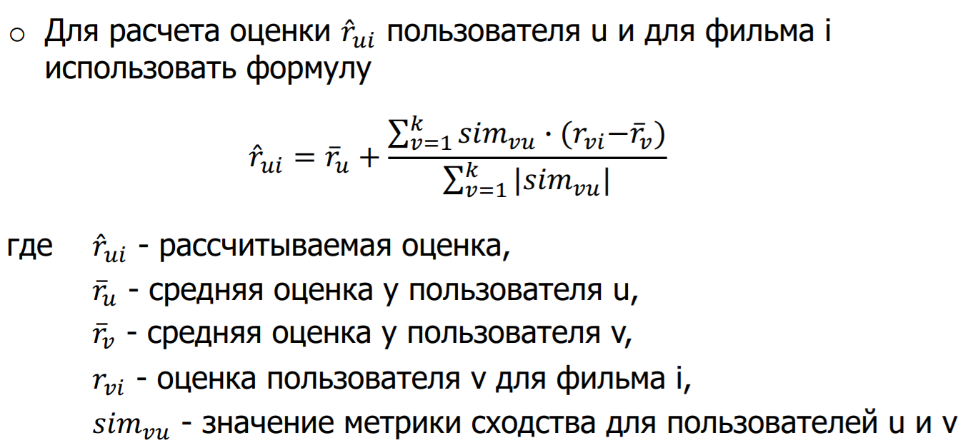

In [6]:
c = 0
film_vac_ev = answer.copy()
data_to_get_sred = data.replace({-1:None}).copy()
films_to_eval_with_context = {}

for film in no_rate:
    sumt = 0
    sumb = 0
    for user in close_ind:
        dU = data_to_get_sred.iloc[[user]] 
        sredu = round(dU.mean(axis = 1),3)
        rate = data.loc[user, film]
        if rate != -1:
            if contday.loc[user, film] in days:
                sumb += sim[user]
                sumt += sim[user] * (data.loc[user, film] - sredu[user])
        films_to_eval_with_context[film] = round(sumt/sumb,3) if sumb !=0 else 0
print(films_to_eval_with_context)

{' Movie 1': 0, ' Movie 11': 0, ' Movie 13': 0, ' Movie 18': 0.424, ' Movie 21': -1.923, ' Movie 28': 0.239}


**Просмотры дома**

In [7]:
for film in no_rate:
    sumt = 0
    sumb = 0
    for user in close_ind:
        dU = data_to_get_sred.iloc[[user]] 
        sredu = round(dU.mean(axis = 1),3)
        rate = data.loc[user, film]
        if rate != -1 and contpl.loc[user, film] == ' h':
            sumb += sim[user]
            sumt += sim[user] * (data.loc[user, film] - sredu[user])
            films_to_eval_with_context[film] += sumt/sumb if sumb !=0 else 0
            films_to_eval_with_context[film] = round(films_to_eval_with_context[film],3)
print(films_to_eval_with_context)

{' Movie 1': 0.875, ' Movie 11': 1.875, ' Movie 13': 0, ' Movie 18': -0.444, ' Movie 21': -0.148, ' Movie 28': 3.533}


In [8]:
data_to_get_sred = data.replace({-1:None}).copy()
sred_v = round(data_to_get_sred.iloc[[variant]].mean(axis = 1),3)
sredv = sred_v[variant]
print("Средняя оценка", sredv)

for film in no_rate:
    films_to_eval_with_context[film] = round(films_to_eval_with_context[film] + sredv,3)
print(films_to_eval_with_context)

Средняя оценка 3.292
{' Movie 1': 4.167, ' Movie 11': 5.167, ' Movie 13': 3.292, ' Movie 18': 2.848, ' Movie 21': 3.144, ' Movie 28': 6.825}


## Дополнительная оценка будет составляться из относительности просмотра фильмов по выходным к общему количеству просмотров (чем больше фильм смотрели, тем более по выходным, тем выше оценка) ##

In [9]:
c = 0
contday = contday.replace({' -1':np.NaN})
film_vac_ev = {}
for film in no_rate:
    c = contday[film].value_counts() 
    sSat = c[[' Sun']]
    sSun = c[[' Sat']]
    c = c.dropna()
    views = c.sum()
    """ основная формула расчёта: отношение суммы просмотров на выходных к общему количеству просмотров ( вычитается из 1, т.к. чем
    выше просмотры => тем меньше дробь, а я в дальнейшем планирую суммировать оценки => мне нужен не меньший, а больший рейтинг)"""
    sumVac = 1 - round((sSat[0] + sSun[0]) / views,3)
    film_vac_ev[film] = sumVac 
        
film_vac_ev


{' Movie 1': 0.656,
 ' Movie 11': 0.7,
 ' Movie 13': 0.667,
 ' Movie 18': 0.645,
 ' Movie 21': 0.774,
 ' Movie 28': 0.706}

In [10]:
c = 0
film_home_ev = {}
contpl = contpl.replace({' -1':np.NaN})
for film in no_rate:
    c = contpl[film].value_counts() 
    sh = c[[' h']]
    c = c.dropna()
    views = c.sum()
    sumh = 1 - round(sh[0] / views,3)
    film_home_ev[film] = sumh
film_home_ev

{' Movie 1': 0.75,
 ' Movie 11': 0.733,
 ' Movie 13': 0.667,
 ' Movie 18': 0.71,
 ' Movie 21': 0.742,
 ' Movie 28': 0.706}

In [11]:
koef = {}
for film in no_rate:
    koef[film] = round(film_home_ev[film] * film_vac_ev[film],3)
print(koef)

{' Movie 1': 0.492, ' Movie 11': 0.513, ' Movie 13': 0.445, ' Movie 18': 0.458, ' Movie 21': 0.574, ' Movie 28': 0.498}


## Общая оценка составлена на основе формулы из 1 части с дополнительным коэффициентом общего просмотра ##

In [217]:
eval_cont = {}
for film in no_rate:
    eval_cont[film] = round(films_to_eval_with_context[film] * koef[film],3)
print("Общие оценки\n",eval_cont)

Общие оценки
 {' Movie 1': 2.05, ' Movie 11': 2.651, ' Movie 13': 1.465, ' Movie 18': 1.304, ' Movie 21': 1.805, ' Movie 28': 3.399}


## Ответ ##

In [216]:
max_key = max(eval_cont, key=lambda k: eval_cont[k])
print("Рекомендуменый фильм:",max_key, "\nЕго оценка:", eval_cont[max_key])

Рекомендуменый фильм:  Movie 28 
Его оценка: 3.399


## Подготовка данных для json ##

In [214]:
import json
answer = dict()

with open('res.json') as f:
    d = json.load(f)

answer = {'user':8, 
          1: d, 
          2: { max_key : eval_cont[max_key]}
         }
answer


{'user': 8,
 1: {' Movie 1': 3.425,
  ' Movie 11': 4.1,
  ' Movie 13': 5.169,
  ' Movie 18': 3.854,
  ' Movie 21': 2.882,
  ' Movie 28': 3.932},
 2: {' Movie 28': 3.399}}

In [213]:
import json
res = json.dumps(answer, indent=4) 
result = json.loads(res)
with open('zyamzina_results.json', 'w') as fl:
    fl.write(json.dumps(result, indent=4) )